# AMG+ for 1D Helmholtz: The Repetitive Case
* Constant $k$.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.

In [517]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [518]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "3-point"
kh = 0
#kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]

repetitive = True

# Test vectors.
ideal_tv = True #. False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 2
# Set # sweeps manually here.
num_sweeps_on_vectors = 1000 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0


## Level 0->1 Coarsening

In [519]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.077e+00                    4.468e-01    2.418
INFO     1     3.922e-01 (0.364) [0.364]    2.569e-01    1.539 (0.635)
INFO     2     1.562e-01 (0.399) [0.381]    1.847e-01    0.855 (0.556)
INFO     3     7.110e-02 (0.455) [0.405]    1.520e-01    0.474 (0.554)
INFO     4     3.759e-02 (0.528) [0.433]    1.331e-01    0.288 (0.605)
INFO     5     2.282e-02 (0.606) [0.463]    1.212e-01    0.193 (0.668)
INFO     6     1.586e-02 (0.695) [0.496]    1.129e-01    0.145 (0.748)
INFO     7     1.183e-02 (0.748) [0.525]    1.067e-01    0.114 (0.793)
INFO     8     9.230e-03 (0.781) [0.552]    1.018e-01    0.093 (0.820)
INFO     9     7.447e-03 (0.806) [0.576]    9.777e-02    0.078 (0.841)
INFO     10    6.171e-03 (0.827) [0.597]    9.433e-02    0.067 (0.859)
INFO     11    5.225e-03 (0.844) [0.617]    9.134e-02    0.059 (0.873)
INFO     12    4.508e-03 (0.859) [0.634]    8.869e-02    0.053 (0.886)
INFO 

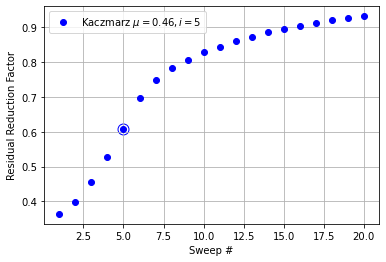

In [520]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [521]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 2 ideal TVs


### Coarsening: Fixed (4/2)

In [522]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
    aggregate_size = 2 #4
    num_components = 1 #2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

,0,1,2,3,4,5,6,7,8,9
0,0.51,0.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.51,0.49,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.51,0.49,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.51,0.49,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.51,0.49


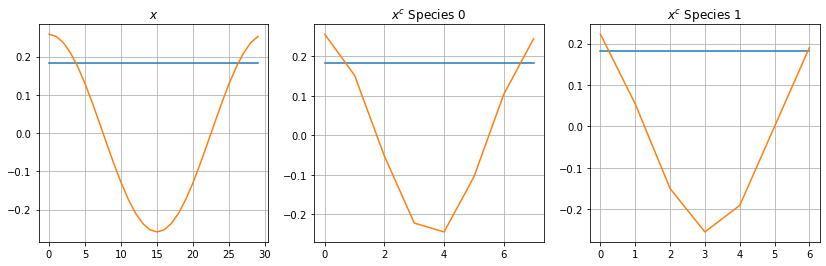

In [523]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=True)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [524]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=8 [0.242 0.115 0.053 0.031 0.017]


### Interpolation $P = R^T$

In [525]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()
print(p.todense())

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "Two-level")).transpose()
display(conv)

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

[[0.513]
 [0.487]]


,1,2,3,4,5
Mock,0.24,0.12,0.05,0.03,0.02
Two-level,0.48,0.43,0.43,0.33,0.36


INFO     L2 projection norm 0.71 A*A' projection norm 1.41


This intepolation is good up to $\nu = 2$, conv $\approx 0.5$.

### Interpolation by LS Fitting

In [526]:
calibers = (2,) #(2, 3, 4)
for use_r_as_restriction in (False, ): #(False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)
        interpolation_method = "ls"
        neighborhood = "extended"

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber)

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))

        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, 
                    use_r_as_restriction=use_r_as_restriction), 
                nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append(two_level_conv)
        p_caliber.append(p)

    conv = pd.DataFrame(np.array([mock_conv] + l2c).transpose(), 
                        index=nu_values, columns=("Mock",) + tuple("Caliber {}".format(caliber)
                                                                  for caliber in calibers)).transpose()
    display(conv)

P^T*A*P
INFO     caliber 2 error l2 [0.01] a [3.50e+11]


,1,2,3,4,5
Mock,0.24,0.12,0.05,0.03,0.02
Caliber 2,0.43,0.21,0.13,0.13,0.07


In [527]:
for caliber, p in zip(calibers, p_caliber):
#    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
#    display_html(styler._repr_html_(), raw=True)
    ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, None, use_r_as_restriction=use_r_as_restriction)
    ac = ml[1].a
    print("caliber {} nnz(P) {} fill-in {:.2f}".format(caliber, p.nnz, (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])))
    print("Max abs |Ac - Ac^T| {:.3e}".format(np.max(np.abs(ac - ac.transpose()))))
    display_df_side_by_side(pd.DataFrame(p[:6, :6].todense()),
                            pd.DataFrame(ac.todense()[:10,:10]), 
                        captions=("P", "A^1"))

caliber 2 nnz(P) 60 fill-in 1.67
Max abs |Ac - Ac^T| 1.110e-16


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 0.76 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.76 
 0.25 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.25 
 0.76 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.76 
 0.25 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.25 
 0.76 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.76 
 0.25 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64

$R A P$ is nearly symmetric, and is sparser than $P^T A P$, while giving almost the same 2-level convergence factors for $\nu \geq 2$.

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 9.118e+00 RER 2.86917
INFO     --------------------------------------------------------------------------------
INFO     Level    Operation          |R|           RER       
INFO     0        initial            1.6647e+00    2.8692e+00
INFO     0        relax 4            1.8326e-01    2.8438e-01
INFO     1        initial            2.0570e-01    3.7913e-01
INFO     1        exact              6.2608e-16    9.6182e-17
INFO     0        correction         1.5729e-01    2.3893e-02
INFO         1 |r| 8.615e-01 (0.09449) RER 0.02389 (0.00833) 36.057
INFO     --------------------------------------------------------------------------------
INFO     Level    Operation          |R|           RER       
INFO     0        initial            1.5729e-01    2.3893e-02
INFO     0        relax 4            1.3308e-02    2.0213e-03
INFO     1        initial            1.3950e-02    2.1216e-03
INFO     1        exact              5.4300e-16    8.6545e-17
INFO     0        correction 

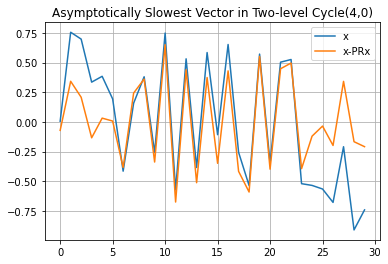

In [528]:
nu = 4
p = p_caliber[0]
multilevel = hm.repetitive.locality.create_two_level_hierarchy(
    kh, discretization, n, R, p, aggregate_size, use_r_as_restriction=False)
y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
                                                   debug=True)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [529]:
print(np.array2string(p.todense()[:2,:2], precision=5))
print(np.array2string(p.sum(axis=1).flatten() - 1, precision=5))
y = np.ones((n,))
p = multilevel[1].p
hm.linalg.scaled_norm(p.dot(R.dot(y)) - y)

p = multilevel[1].p
a = multilevel[0].a
ac = p.H.dot(a.dot(p))
ac.sum(axis=1).flatten()

[[0.76276 0.     ]
 [0.75742 0.25372]]
[[0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113 0.01165 0.01113]]


matrix([[-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]])

In [530]:
print(np.array(a.sum(axis=1)).flatten())
print(np.array(multilevel[1].a.sum(axis=1)).flatten())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]


In [531]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [ 0.    -0.044 -0.044 -0.173 -0.173 -0.382 -0.382 -0.662 -0.662 -1.    -1.    -1.382]
1 lam [-0.    -0.087 -0.087 -0.311 -0.311 -0.586 -0.586 -0.822 -0.822 -0.966 -0.966 -1.024]


#### $R A P$

In [532]:
# nu = 4
# p = p_caliber[-1]
# multilevel = hm.repetitive.locality.create_two_level_hierarchy(
#     kh, discretization, n, R, p, aggregate_size, use_r_as_restriction=True)
# y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
#                                                    debug=False)

# # Asymptotic vector.
# plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
# plt.plot(y, label="x");
# plt.plot(e, label="x-PRx");
# plt.grid(True);
# plt.legend();

In [533]:
# y.T.dot(multilevel[0].a.dot(y)) / (y.T.dot(y))

In [534]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [ 0.    -0.044 -0.044 -0.173 -0.173 -0.382 -0.382 -0.662 -0.662 -1.    -1.    -1.382]
1 lam [-0.    -0.087 -0.087 -0.311 -0.311 -0.586 -0.586 -0.822 -0.822 -0.966 -0.966 -1.024]


# Workspace

In [535]:
caliber = 2

In [536]:
print("aggregate_size", aggregate_size, "num_components", num_components, "n", multilevel.finest_level.a.shape[0])
max_caliber = 4
nc = num_components
num_aggregates = int(np.ceil(multilevel.finest_level.a.shape[0] / aggregate_size))
num_coarse_vars = nc * num_aggregates
nbhr = np.mod(hm.setup.interpolation.geometric_neighbors(aggregate_size, nc), num_coarse_vars)

# Ridge regularization parameter (list of values).
alpha = np.array([0, 0.01, 0.1, 0.1, 1])

# Prepare fine and coarse test matrices.
xc = R.dot(x)
if repetitive:
    x_disjoint_aggregate_t, xc_disjoint_aggregate_t = \
        hm.setup.sampling.get_disjoint_windows(x, xc, aggregate_size, nc, max_caliber)

# Create folds.
num_test_examples = 5
num_examples = int(x_disjoint_aggregate_t.shape[0])
num_ls_examples = num_examples - num_test_examples
val_samples = int(0.2 * num_ls_examples)
fit_samples = num_examples - val_samples - num_test_examples

# Increase caliber (fitting interpolation with LS) until the test error A-norm is below the accuracy threshold.
max_caliber = min(max_caliber, max(len(n) for n in nbhr))

# Create an interpolation over the samples: a single aggregate (if repetitive) or entire domain (otherwise).
p = hm.setup.interpolation_ls_fit.create_interpolation_least_squares(
    x_disjoint_aggregate_t, xc_disjoint_aggregate_t, [n[:caliber] for n in nbhr],
    alpha=alpha, fit_samples=fit_samples, val_samples=val_samples, test_samples=num_test_examples)

aggregate_size 2 num_components 1 n 30


In [537]:
display(pd.DataFrame(R[:num_components, :aggregate_size].todense()))
print(nbhr)
coarse_nbhr = np.unique(nbhr.flatten())
print(coarse_nbhr)
pd.DataFrame(p[:, coarse_nbhr].todense())

np.concatenate((x_disjoint_aggregate_t[:, 0][:, None], xc_disjoint_aggregate_t[:, nbhr[0]]), axis=1)[:10]
i = 0
A, B = xc_disjoint_aggregate_t[:, nbhr[i]], x_disjoint_aggregate_t[:, i]
print(np.linalg.lstsq(A, B, rcond=None))
#plt.plot(x);

,0,1
0,0.51,0.49


[[ 0 14]
 [ 0  1]]
[ 0  1 14]
(array([0.765, 0.246]), array([0.]), 2, array([1.395, 0.207]))


In [659]:
sz = 10
m = 4
y = np.arange(2*sz).reshape(sz, 2)
print(y)

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]


In [660]:
offset = (m + 1) // 2 - 1
print(offset, m - offset)
z = np.concatenate((y[-offset:], y, y[:m - offset - 1]))
print(z)
indices = np.array(list(zip(range(sz), range(m, sz + m)))).flatten()
interval_norm = ((np.add.reduceat(z, indices[:-1])[::2]))
print(interval_norm)

1 3
[[18 19]
 [ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]
 [ 0  1]
 [ 2  3]]
[[24 28]
 [12 16]
 [20 24]
 [28 32]
 [36 40]
 [44 48]
 [52 56]
 [60 64]
 [48 52]
 [36 40]]


In [661]:
expected = np.array(
    list(map(
    lambda x: sum(x),
    (np.array([y[j % sz] for j in range(i - (m + 1) // 2 + 1, i - (m + 1) // 2 + 1 + m)])
        for i in range(sz)))))
expected

array([[24, 28],
       [12, 16],
       [20, 24],
       [28, 32],
       [36, 40],
       [44, 48],
       [52, 56],
       [60, 64],
       [48, 52],
       [36, 40]])

In [662]:
(expected - interval_norm)

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]])

In [663]:
m // 2 - 1

1

In [632]:
m = 5; (m + 1) // 2 - 1

2